In [15]:
import pandas as pd
import bz2
import datetime
import matplotlib.pyplot as plt

messages.csv (The Event Log)
Each row is one event that changed the market, like:

- Someone placed a new order

- Someone canceled an order

- An order was partially or fully executed

What each row tells you:

- When it happened (to the microsecond)

- What kind of event it was (e.g., new order, cancel)

- How big the order was (100 shares, 500 shares, etc.)

- What price they wanted

- Whether it was a buy or sell

This is like a logbook of everything that happened in the market — in exact order.

In [4]:
# loading the lobster file

message = pd.read_csv('/Users/manika/Desktop/Python : Learning/market-microstructure-analyzer/data/raw/AAPL_2012-06-21_34200000_57600000_message_10.csv',header=None)
message.head()


,0,1,2,3,4,5
0,34200.004241,1,16113575,18,5853300,1
1,34200.004261,1,16113584,18,5853200,1
2,34200.004447,1,16113594,18,5853100,1
3,34200.025552,1,16120456,18,5859100,-1
4,34200.025580,1,16120480,18,5859200,-1


In [8]:
message.columns = ['time','type','order_id','size','price','direction']
# the time column is the in miliseconds after the market opens at 9am 
# creating a new datetime column for readability
base_time = datetime.datetime(2024,1,1)
message['datetime'] = message['time'].apply(lambda x: base_time+datetime.timedelta(seconds=x))


orderbook.csv (The Order Book Snapshot)
After each event, the market has a new “state” — a new arrangement of:

- Who wants to buy shares (and how many)

- Who wants to sell shares (and how many)

Think of it like:

- A ranked list of the top 10 best bids (buy offers)

- And top 10 best asks (sell offers)

The orderbook.csv shows that snapshot of the top 10 buyers and sellers immediately after each message.

In [ ]:
# These show the state of the market (the limit order book) after each event.
order = pd.read_csv('/Users/manika/Desktop/Python : Learning/market-microstructure-analyzer/data/raw/AAPL_2012-06-21_34200000_57600000_orderbook_10.csv',header=None)


Renaming Order columns:
Column Index	Meaning
0–9	    Bid prices (levels 1 to 10)
10–19	Bid volumes
20–29	Ask prices
30–39	Ask volumes

In [21]:
col_name =[]

for i in range (1,11):
    col_name.append(f'bid_price{i}')
for i in range(1,11):
    col_name.append(f'bid_volume{i}')
for i in range (1,11):
    col_name.append(f'ask_price{i}')
for i in range (1,11):
    col_name.append(f'ask_volume{i}')

order.columns = col_name
order.head()



,bid_price1,bid_price2,bid_price3,bid_price4,bid_price5,bid_price6,bid_price7,bid_price8,bid_price9,bid_price10,...,ask_volume1,ask_volume2,ask_volume3,ask_volume4,ask_volume5,ask_volume6,ask_volume7,ask_volume8,ask_volume9,ask_volume10
0,5859400,200,5853300,18,5859800,200,5853000,150,5861000,200,...,5845300,300,5876500,1160,5843800,200,5879000,500,5842700,300
1,5859400,200,5853300,18,5859800,200,5853200,18,5861000,200,...,5846500,300,5876500,1160,5845300,300,5879000,500,5843800,200
2,5859400,200,5853300,18,5859800,200,5853200,18,5861000,200,...,5849300,300,5876500,1160,5846500,300,5879000,500,5845300,300
3,5859100,18,5853300,18,5859400,200,5853200,18,5859800,200,...,5849300,300,5873900,100,5846500,300,5876500,1160,5845300,300
4,5859100,18,5853300,18,5859200,18,5853200,18,5859400,200,...,5849300,300,5871000,10,5846500,300,5873900,100,5845300,300


In [23]:
# doing column wise merge to get limit order book + event stream
df = pd.concat([message,order],axis=1)
df.head()

,time,type,order_id,size,price,direction,datetime,bid_price1,bid_price2,bid_price3,...,ask_volume1,ask_volume2,ask_volume3,ask_volume4,ask_volume5,ask_volume6,ask_volume7,ask_volume8,ask_volume9,ask_volume10
0,34200.004241,1,16113575,18,5853300,1,2024-01-01 09:30:00.004241,5859400,200,5853300,...,5845300,300,5876500,1160,5843800,200,5879000,500,5842700,300
1,34200.004261,1,16113584,18,5853200,1,2024-01-01 09:30:00.004261,5859400,200,5853300,...,5846500,300,5876500,1160,5845300,300,5879000,500,5843800,200
2,34200.004447,1,16113594,18,5853100,1,2024-01-01 09:30:00.004447,5859400,200,5853300,...,5849300,300,5876500,1160,5846500,300,5879000,500,5845300,300
3,34200.025552,1,16120456,18,5859100,-1,2024-01-01 09:30:00.025552,5859100,18,5853300,...,5849300,300,5873900,100,5846500,300,5876500,1160,5845300,300
4,34200.025580,1,16120480,18,5859200,-1,2024-01-01 09:30:00.025580,5859100,18,5853300,...,5849300,300,5871000,10,5846500,300,5873900,100,5845300,300


Basic Visualizations

1) Mid Price Over Time — Tells Us Market Movement
   The mid price is like a "fair value" estimate based on current supply (asks) and demand (bids).

   Plotting it shows how the market price responds to events (buy orders, cancels, etc.)

   We can spot suspicious jumps or volatility:

    - Did price suddenly jump after a massive cancel order?

    - Does price move up without actual trades? → could hint at spoofing



In [16]:
# Mid-price = (Best Bid + Best Ask) / 2 / 10000 -> LOBSTER Data Uses Price in 10,000ths of a Dollar
df['mid_price'] = (df['bid_price1'] + df['ask_price1'])/2/ 10000


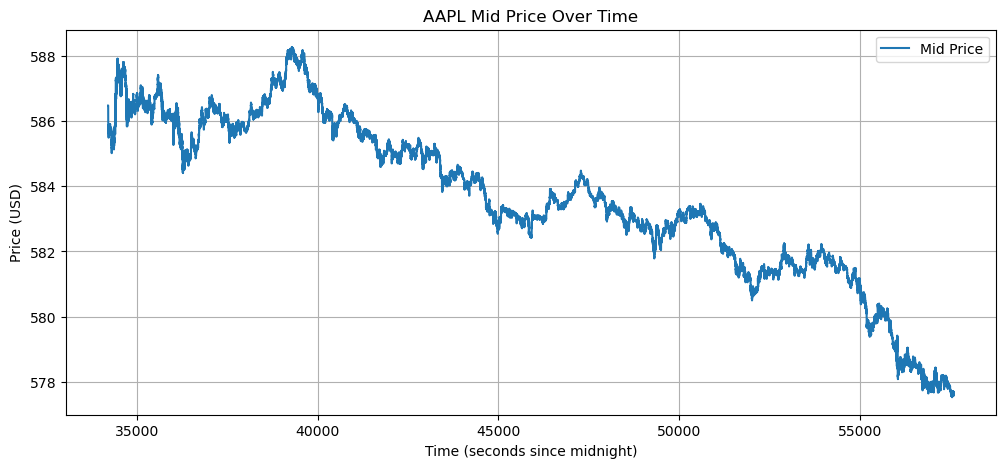

In [18]:

plt.figure(figsize=(12, 5))
plt.plot(df['time'], df['mid_price'], label='Mid Price')
plt.xlabel('Time (seconds since midnight)')
plt.ylabel('Price (USD)')
plt.title('AAPL Mid Price Over Time')
plt.legend()
plt.grid(True)
plt.show()

2) Visualize Volume Imbalance - Reveals Market Pressure
- Are there way more buyers or sellers at any given time?

- An imbalance shows if the market is bullish (lots of buyers) or bearish (lots of sellers)

If imbalance swings wildly back and forth, it could mean:

- Someone is placing/canceling orders quickly → classic quote stuffing

- Fake orders that push others to react → a sign of spoofing


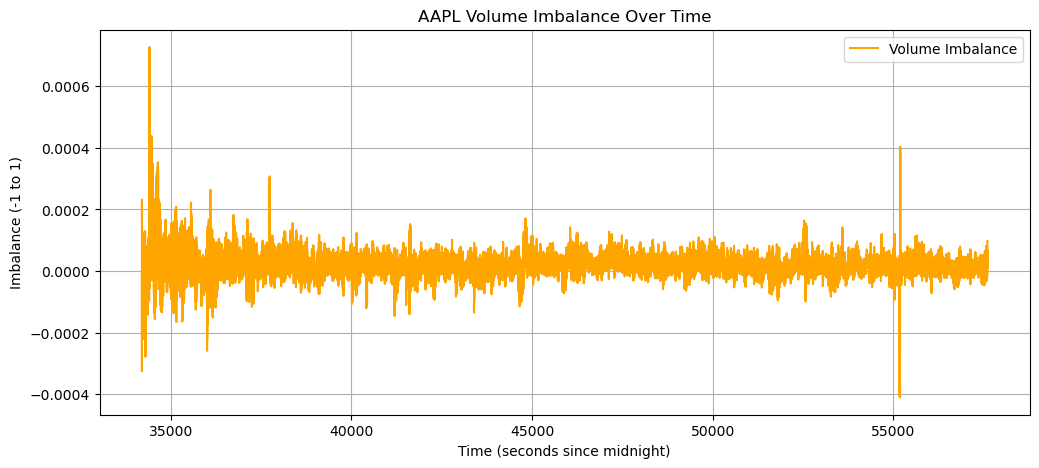

In [ ]:
# Calculate volume imbalance 
df['bid_volume_total'] = df[[f'bid_volume{i}' for i in range(1, 11)]].sum(axis=1)
df['ask_volume_total'] = df[[f'ask_volume{i}' for i in range(1, 11)]].sum(axis=1)

df['volume_imbalance'] = (df['bid_volume_total'] - df['ask_volume_total']) / (df['bid_volume_total'] + df['ask_volume_total'])

# Plot it
plt.figure(figsize=(12, 5))
plt.plot(df['time'], df['volume_imbalance'], color='orange', label='Volume Imbalance')
plt.xlabel('Time (seconds since midnight)')
plt.ylabel('Imbalance (-1 to 1)')
plt.title('AAPL Volume Imbalance Over Time')
plt.legend()
plt.grid(True)
plt.show()


In [27]:
df.to_csv('/Users/manika/Desktop/Python : Learning/market-microstructure-analyzer/data/df_merged.csv')

In [29]:
df

,time,type,order_id,size,price,direction,datetime,bid_price1,bid_price2,bid_price3,...,ask_volume4,ask_volume5,ask_volume6,ask_volume7,ask_volume8,ask_volume9,ask_volume10,bid_volume_total,ask_volume_total,volume_imbalance
0,34200.004241,1,16113575,18,5853300,1,2024-01-01 09:30:00.004241,5859400,200,5853300,...,1160,5843800,200,5879000,500,5842700,300,29289649,29289760,-0.000002
1,34200.004261,1,16113584,18,5853200,1,2024-01-01 09:30:00.004261,5859400,200,5853300,...,1160,5845300,300,5879000,500,5843800,200,29293094,29293560,-0.000008
2,34200.004447,1,16113594,18,5853100,1,2024-01-01 09:30:00.004447,5859400,200,5853300,...,1160,5846500,300,5879000,500,5845300,300,29296023,29299160,-0.000054
3,34200.025552,1,16120456,18,5859100,-1,2024-01-01 09:30:00.025552,5859100,18,5853300,...,100,5846500,300,5876500,1160,5845300,300,29287673,29293660,-0.000102
4,34200.025580,1,16120480,18,5859200,-1,2024-01-01 09:30:00.025580,5859100,18,5853300,...,10,5846500,300,5873900,100,5845300,300,29278473,29287010,-0.000146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400386,57599.444020,1,287150868,48,5776100,-1,2024-01-01 15:59:59.444020,5776100,48,5775400,...,100,5774500,200,5777700,100,5774300,100,28884699,28879300,0.000093
400387,57599.444795,1,287150931,100,5777200,-1,2024-01-01 15:59:59.444795,5776100,48,5775400,...,600,5774500,200,5777600,100,5774300,100,28884699,28879600,0.000088
400388,57599.625827,3,286898608,100,5774900,1,2024-01-01 15:59:59.625827,5776100,48,5775400,...,600,5774500,200,5777600,100,5774300,100,28884699,28879600,0.000088
400389,57599.913118,4,287150868,48,5776100,-1,2024-01-01 15:59:59.913118,5776700,300,5775400,...,100,5774500,200,5777800,200,5774300,100,28885139,28879500,0.000098
